# Training a Satellite to Orbit a Planet in 2D Space with Neural Network Reinforcement Learning
### Derek Strobel - dstrobel@rams.colostate.edu

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import physics

In [2]:
import io
import base64
from IPython.display import HTML
# https://stackoverflow.com/questions/18019477/how-can-i-play-a-local-video-in-my-ipython-notebook
video = io.open('video/21-22.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video width=640 height=480 alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

## Introduction

In this project, my goal was to use reinforcement learning with neural networks to train an agent to pilot a small satellite in 2-dimensional space. The goal of the problem is to train the agent to reach a stable orbit around a large celestial object. In designing this problem, I did not focus on physical realism; the problem is designed to be a simple, noiseless, deterministic space.

One of the main goals I had going into this project was to represent the state of the problem as minimally as possible to simplify the problem for the agent to expediate learning. This is a tricky problem, because in simplifying the state representation, it's possible to make assumptions about what factors are important in the problem that will actually impede the learning of an optimal solution if those assumptions are not valid. Because of this, I put a lot of effort into considering how I could reduce the data required to represent the state of the problem without obstructing the information the agent needed to learn. 

There are such a large number of hyperparameters and approaches to be tuned and considered when using neural network reinforcement learning that I could not possibly perform meaningful tests of all of those behaviors in the time frame I had. So, instead of collecting data on the behavior of all of these parameters, I just did my best to make a guess and stopped when I saw reasonably good performance. Hyperparameter tuning was not the main focus of this project.

## Problem Design
#### State - Represented by 2 Values
* $D$ - The Euclidean distance from the center of the satellite to the center of the planet (in pixels)
* $V_p$ - The magnitude of the component of the ball's velocity (in pixels per step) in the direction of the planet (positive when the ball is travelling toward the planet, negative when it's travelling away, and zero when it's travelling perpendicular)

#### Action - Represented by 2 Values
* $M$ - The magnitude of thrust to be exerted by the satellite (discrete from 0 to 10)
* $\theta$ - The direction of thrust to be exerted by the satellite (discrete from 0 to $2\pi$ in steps of $\frac{\pi}{12}$)

Every step of the environment, the planet exerts a gravitational force based on Newton's law (inversely proportional to the distance between the objects squared) on the satellite. I assumed for the sake of simplicity that the gravitational force that the satellite exerts on the planet is negligible. I did not go to any significant length to consider realistic proportions of the physical sizes of the objects; I focused more on creating an interesting reinforcement learning control problem that I could solve in a reasonable amount of time.

By using this relative representation of state instead of one which used the absoulte position of the satellite, I collapsed the state space significantly. The philosiphy behind this decision is that with an intuition of physics, I know that the satellite should not see the state of being above the planet and hurtling towards it with some velocity as any different physically than being below the planet and hurtling toward it with that same velocity. 

Thus, by representing the state space relative to the planet, I'm effectively using a bit of my knowledge of the environment to relieve the agent of the effort of learning a uniform function across the absolute state space. I did not perform any experiments to validate this decision, but I would be interested to perform some in the future.

In the video I show above, the large gray circle represents the planet, the small white circle represents the satellite, and the green ring represents the desired orbital altitude. The red line represents the total absolute velocity of the satellite while the blue line represents the thrust action taken by the agent at that state.

#### Reinforcement Function
For this problem, I decided to use a continuous reinforcement function. I wanted to design a function of the state of the problem such that it had a very high result when the distance between the satellite and the planet was near the desired orbital altitude and very low in all other places. Instead of using a discrete reward function (1 when the satellite is within some threshold and 0 otherwise), I decided to design a continuous function with a slightly less steep gradient with the hope that it would encourage the agent to explore more of the state space.

The function I designed is as follows:

$\large{r(D)} = \LARGE{\frac{a}{cosh^2((D - \lambda) / \eta)}}$

where:
* $a$ is an amplitude factor; how much to exaggerate the difference between good behavior and bad behavior
* $\lambda$ is a shift factor; the optimal orbital altitude
* $\eta$ is a stretch factor; (inversely) how steep to make the gradient of the reward function

I designed this function based on the derivative of the hyperbolic tangent function, which is commonly used as an activation function in neural networks for precisely the same reason that I used it; its derivative is 1 at zero and slopes downward symmetrically on either side. This way, I encourage the agent to pilot in the optimal range; straying too close to or too far away from the planet will result in a continuous decline in reward.

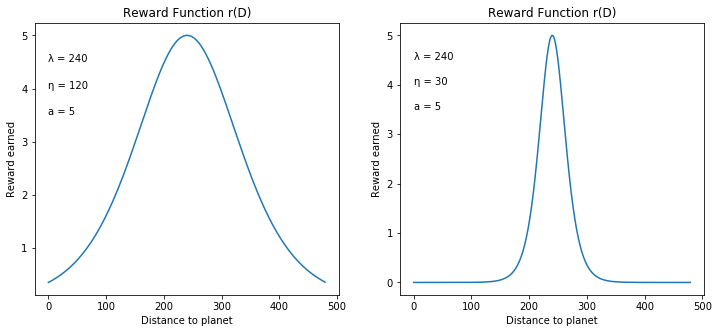

In [10]:
fig,ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot([physics.dtanh(x, amp=5, shift=240, stretch=120) for x in range(0,480)])
ax[0].set_xlabel('Distance to planet')
ax[0].set_ylabel('Reward earned')
ax[0].set_title('Reward Function r(D)')
ax[0].text(0,4.5,'\u03BB = 240')
ax[0].text(0,4,'\u03B7 = 120')
ax[0].text(0,3.5,'a = 5')

ax[1].plot([physics.dtanh(x, amp=5, shift=240, stretch=30) for x in range(0,480)])
ax[1].set_xlabel('Distance to planet')
ax[1].set_ylabel('Reward earned')
ax[1].set_title('Reward Function r(D)')
ax[1].text(0,4.5,'\u03BB = 240')
ax[1].text(0,4,'\u03B7 = 30')
ax[1].text(0,3.5,'a = 5')

I found that you can affect the behavior of the agent greatly by modifying the amplitude and stretch factors. The most effective reward functions seemed to be ones with a relatively high $\alpha$ and relatively low $\eta$; in other words, those that emphasized good behavior with a very small tolerance window for error (closer to the plot on the right).

## Agent Design

There are two main categories in currently popular reinforcement learning temporal difference algorithms: SARSA and Q-Learning. This project was not meant to be a contrast of the two, so I did not perform any experiments to compare them. The algorithms are very similar from an implementation perspective, so I implemented them both; SARSA tends to converge slightly faster but I did not notice any other glaring differences with minor experimentation.

The model I used to learn a Q function with neural networks was heavily inspired by research I did on similar implementations, mostly by [this](https://gym.openai.com/evaluations/eval_EIcM1ZBnQW2LBaFN6FY65g/) implementation of a Q-Learning agent to solve the famous cartpole problem as implemented in OpenAI (a framework I also made use of). The most important concept that I adopted from this implementation was that the neural network used to approximate the Q function should not be a function of a state-action pair that produces one Q value; instead, it should be a function of the state only which produces one output per action that could be taken at that state. The benefit of this, I believe, is twofold: the implementation is much simpler and it reduces the number of inputs to the model, effectively simplifying it and hopefully expediating training.

Another concept that I drew heavily on from this example is the use of experience replay. The design I used simply records a SARSA tuple at every state visited into the replay memory of the agent, which is a buffer of some fixed size. Training is done at the end of every episode, but not necessarily on the data just collected; instead, all training is done on a random sample of a fixed size of the experience replay buffer. This way, recent memories are not more prioritized, hopefully leading to better long-term performance.

Yet another concept I saw around the web and in the particular example I linked (whose approach I borrowed) was to use a logarithmic decay of $\epsilon$, the random action factor. The approach of decaying slowly at first, then picking up pace and finally flattened out seemed to improve performance over a linear decay, though I did not have time to collect data on this variable.

To simplify the math in the DQL and SARSA updates, I used an $\alpha$ learning rate of 1 and simply controlled the learning rate of the agent using the network's learning rate and the number of training iterations to perform on each batch of samples. Most of my later models used a relatively high $\gamma$ discount factor (~0.8 to 0.9) to prioritize long-term rewards.

Optimizing the structure of the network I used was also not a focus of this assignment, but I found success using a decently-sized 6-layer network of 32 hidden units each, all activated with hyperbolic tangent, optimized using the recent [Adam](https://arxiv.org/abs/1412.6980) optimization algorithm (simply a popular choice, I found similar performance using stochastic gradient descent) and using mean squared error as the error function. 

## Implementation

For the overall reinforcement learning interaction loop, I (lightly) used the [OpenAI](https://github.com/openai/gym) framework. The class `Planet` that i wrote in `planet.py` is a subclass of the OpenAI `env` type which represents an environment that an agent can interact with. The actual interaction loop is implemented in the `orbit.py` script, which can be run with a few different command-line parameters. The structure of this script was built on the basic starting point that OpenAI provides to run a random agent on their implementation of the cartpole problem, found [here](https://github.com/openai/gym/blob/master/examples/agents/random_agent.py). It uses the fantastic Python argparse package to manage command line arguments.

To simulate the physical environment of the problem I simply implemented a barebones physics engine (<100 lines). I did not need any features provided from a standard physics engine package besides basic acceleration and gravitational motion, which many packages do not provide in the form my problem required. This code is not generalized or structured, nor is it designed to be used in any problem but this one. It can be found throughout `physics.py` and `planet.py`.

To render the environment, I used [PyGame](http://www.pygame.org/news). The renders are fairly quick, and PyGame also allows you to write image files of the screen to the disk; I used this along with the video encoder `ffmpeg` (along with some [help from StackOverflow](https://stackoverflow.com/questions/36016192/render-and-save-a-video-file-with-python)) to compile the images saved into a `.mp4` video if desired.

For neural networks, I used [PyTorch](http://pytorch.org/) with the intention of training my models using GPUs. Due to time constraints, I did not have time to fully implement or test this; however, I would like to experiment with this code on GPUs in the future, and hopefully it would be relatively straightforward to do with my PyTorch code.

My project generated a reasonable amount of fairly messy code; it may be fairly difficult to read and parse as it is not well documented. If you have any questions about a particular piece of code in one of the files I included, feel free to contact me.

The temporal difference error calculation happens in the `trainQ` method of the `QAgent` class I wrote in `agents.py`. 

#### Q Learning
```
for i,o in enumerate(observations):
    qs[i,self.all_actions.index(actions[i])] = self.qlr * (rewards[i] + self.gamma * torch.max(self.Q(Variable(nextobs[i])).data)) # qlearning
``` 

#### SARSA
```
for i,o in enumerate(observations):
    qs[i,self.all_actions.index(actions[i])] += self.qlr * (rewards[i] + self.gamma * self.Q(Variable(nextobs[i])).data[self.all_actions.index(nextas[i])] - qs[i,self.all_actions.index(actions[i])]) # sarsa
```

Both of these sections are left in the `trainQ` method; I just commented one out when I wanted to test the other. As mentioned before, I did not experience any drastic change in performance between the two approaches, and choosing between the two was not the focus of this discussion.

The structure of the agent-environment interaction loop is as follows:

* for $n$ episodes:
    * reset environment
    * while environment has not terminated:
        * take action $a'$ from state $S'$ according to $\epsilon$-greedy policy, earning some reward $r$ and resulting in state $S''$
        * add ($S$, $a$, $r$, $S'$, $a'$) to the agent's experience replay memory
        * consider $S''$ as $S'$, $a'$ as $a$, and $S'$ as $S$
    * decay the agent's $\epsilon$ factor
    * train the agent on $\beta$ memories from its experience replay memory

## Results

The video I showed at the beginning of the report was of a SARSA agent performing 2000 trials of the environment. As you can see, there looks to be some meaningful learning at a few points, particularly during a few trials where the agent performed exceptionally. Here are a few plots of the performance of that particular agent (the same one showed in the video above):

<img src="plots/53.png" alt="SARSA Agent" style="width: 600px;"/>

The reward plot shows the reward achieved by the agent. The first few hundred trials were at $\epsilon=1$, and did not exceed around 200 reward (The maximum reward possible to be earned on a single timestep was 5). The performance seems to have a fairly clear increase as the $\epsilon$ factor decays. By the 10,000th trial, the agent seems to be performing significantly better (max of around 750) than random behavior fairly consistently. After that, around the 15,000th trial, the agent experiences a huge jump in performance, above 2,000 at the highest. Because the epsilon factor was still around 0.25 at this point, it's unclear whether this jump in performance was due to some insight learned by the agent or due to a series of lucky random actions. However, immediately following this huge performance jump, the agent seems to drop signifantly in performance very suddenly. Though I did not have enough time to thoroughly experiment with the cause of this drop, my guess would be that the experiences randomly selected to replay after did not contain the high-performance memories and thus these memories may not have had the impact that one may expect.

While this was only one run of the program with one set of hyperparameters using SARSA, I was not able to significantly improve performance with very limited experimentation of hyperparameter modification. Though I would like to continue to experiment with tuning these parameters in the future, optimizing the performance of the agent was not within the scope of this project.

<img src="plots/1120.png" alt="Better SARSA Agent" style="width: 600px;"/>

Here is a much more convincing plot of the performance of another agent, this time using Q-Learning. 

## Analysis and Future Improvements

Overall I am very happy with the progress I achieved in this project. I was able to generate a concept for a unique control problem, implement it, and implement an agent to solve the problem mostly from scratch with reasonable success. While the performance achieved by the agents I trained was anything but optimal, I think it's fair to say some interesting results were achieved. I think the most important part of the positive results of this project was the simplification of the state space. While I believe that using knowledge of the environment of the problem to perform this simplification was beneficial to the learning of the agent, it's difficult to say without performing more experiments. The evidence that I obtained which I found most convincing to this end was simply that I was unable to determine any evidence of meaningful learning ocurring in agents which observed an absolute state of the problem (absolute position and velocity) as opposed to the relative version presented above, which did seem to show some meaningful performance increase.

Running the program with the hyperparameters I have set seems to consistently yield increasing performance over time, as you can see by running it for yourself below. As I did not perform any real structured experiments to tune the parameters due to time constraints and simply experimented until I achieved a noticeable performance increase, I think this is strong evidence that by taking steps to optimize performance, the agent could be improved in both stability and training speed. 

In the future, I would like to experiment with this by testing the performance of agents in the same problem but with the state represented in different ways. I also would really like to experiment with using convolutional neural networks to represent the state of the problem absolutely as simply the rendered pixel array of the screen generated by PyGame to determine if an agent could solve the problem simply by observing the state visually as a human would. Of course, I would also like to experiment with the hyperparameters of the problem - the reinforcement funciton $r(D)$, the discount factor $\gamma$, the Adam or SGD learning rate of the Q-network, the number of samples to train on from the experience replay buffer after every trial, and so on. I believe that this problem could be solved very accurately by experimenting with the state representation and hyperparameters as I have presented them.

## Running the Program

In [23]:
%run orbit.py --help

usage: orbit.py [-h] [--cuda CUDA] [--mode MODE] [--render-after RENDER_AFTER]
                [--render-every RENDER_EVERY] [--n N]
                [--record-every RECORD_EVERY]

optional arguments:
  -h, --help            show this help message and exit
  --cuda CUDA           Use cuda for PyTorch tensor operations
  --mode MODE           Mode to run the simulation in. "human"->Render each
                        frame of each trial. "batch"->Do no rendering.
                        "video"->record video to .jpg and then .mp4 files.
  --render-after RENDER_AFTER
                        Only render after x episodes
  --render-every RENDER_EVERY
                        Only render every x episodes
  --n N                 Number of trials to run
  --record-every RECORD_EVERY
                        Only record a video of every x episodes


To run the program, your system will need to have installed:

* Python 3+ with anaconda
* PyTorch
* OpenAI Gym
* PyGame
* ffmpeg (if video output is desired - videos are typically <2mb for 20,000 trials recording every 400 trials) after encoding and deleting each .jpg frame from the `images` subdirectory of the project

If you want to run my program but can't get it to work, please contact me at dstrobel@rams.colostate.edu.

Some commands to perform sample run of the rendered program which I believe should produce some interesting results: 

To record video every 400 episodes:
<font color='red' face='Courier New'>
<strong>
python orbit.py --mode=video --record-every=400
</strong>
</font>

To simply render and not record video every 50 episodes:
<font color='red' face='Courier New'>
<strong>
python orbit.py --mode=human --render-every=50
</strong>
</font>

Note: There is an issue where after execution the plot showing performance will show but the program will not close due to the PyGame window; I never resolved this issue, so the program has to be manually terminated by closing the terminal window after running. Because of this I would reccomend running them in a terminal window instead of in the notebook. You can also refer to the videos I recorded and included if you don't want to run and record videos from scratch. Sorry!

Conversely, you can run the program without rendering the screen from jupyter notebook. Here's an executable example:

Ep 0 done in 0.32s; eps=1.000; qlr = 1.00000 Scored 14.65
Ep 700 done in 53.37s; eps=1.000; qlr = 1.00000 Scored 13.19
Ep 1400 done in 104.49s; eps=1.000; qlr = 1.00000 Scored 9.70
Ep 2100 done in 155.06s; eps=1.000; qlr = 1.00000 Scored 10.21
Ep 2800 done in 206.35s; eps=1.000; qlr = 1.00000 Scored 8.70
Ep 3500 done in 257.97s; eps=1.000; qlr = 1.00000 Scored 7.52
Ep 4200 done in 310.08s; eps=0.870; qlr = 1.00000 Scored 9.67
Ep 4900 done in 362.06s; eps=0.769; qlr = 1.00000 Scored 10.24
Ep 5600 done in 415.26s; eps=0.688; qlr = 1.00000 Scored 8.82
Ep 6300 done in 468.03s; eps=0.620; qlr = 1.00000 Scored 49.28
Ep 7000 done in 521.34s; eps=0.561; qlr = 1.00000 Scored 7.93
Ep 7700 done in 575.51s; eps=0.509; qlr = 1.00000 Scored 7.91
Ep 8400 done in 629.49s; eps=0.462; qlr = 1.00000 Scored 0.46
Ep 9100 done in 683.27s; eps=0.420; qlr = 1.00000 Scored 8.22
Ep 9800 done in 737.71s; eps=0.382; qlr = 1.00000 Scored 11.75
Ep 10500 done in 792.09s; eps=0.347; qlr = 1.00000 Scored 11.58
Ep 1120

//anaconda/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


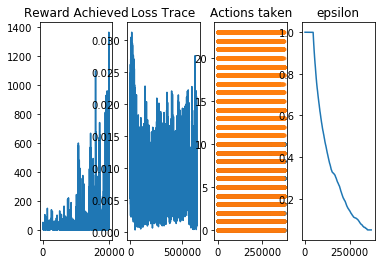

In [1]:
%run orbit.py --mode=batch --render-every=700 --n=20000

The above run of the program both took around 30 minutes on my laptop, so with more serious processing power it should complete in a reasonable amount of time. There are also more videos of the program running in the `videos` directory, with corresponding plots in the `plots` directory. I apologize that these are not labeled with the hyperparameters used to train them, but you can get a good idea of the success of a small set of parameters with very small variation from these results.